In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from src import RGBDataset, RGBDataModule, RGBModule

In [3]:
path = Path("../data")
os.listdir(path)

['metadata',
 'observations',
 'patches-fr',
 'patches-us',
 'patches_sample',
 'pre-extracted',
 'rasters',
 'sample_submission.csv']

In [4]:
pd.read_csv(path / "sample_submission.csv")

,Id,Predicted
0,10000293,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,10000302,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,10000346,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,10000468,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,10000481,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
...,...,...
36416,22067746,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
36417,22067972,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
36418,22068007,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
36419,22068076,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [5]:
os.listdir(path / "observations")

['observations_fr_test.csv',
 'observations_fr_train.csv',
 'observations_us_test.csv',
 'observations_us_train.csv']

In [6]:
#data_train = pd.concat([obs_fr, obs_us])
#data_train

In [7]:
dm = RGBDataModule()
dm.setup()

train: 1587395
val: 40080
test: 36421


In [8]:
dm.data_train

,observation_id,latitude,longitude,species_id,subset,image
0,10561949,45.705116,1.424622,241,train,../data/patches-fr/49/19/10561949_rgb.jpg
1,10131188,45.146973,6.416794,101,train,../data/patches-fr/88/11/10131188_rgb.jpg
2,10799362,46.783695,-2.072855,700,train,../data/patches-fr/62/93/10799362_rgb.jpg
3,10392536,48.604866,-2.825003,1456,train,../data/patches-fr/36/25/10392536_rgb.jpg
4,10335049,48.815567,-0.161431,157,train,../data/patches-fr/49/50/10335049_rgb.jpg
...,...,...,...,...,...,...
956225,22068170,38.205840,-122.758660,8451,train,../data/patches-us/70/81/22068170_rgb.jpg
956226,22068171,29.602327,-94.555860,5041,train,../data/patches-us/71/81/22068171_rgb.jpg
956227,22068172,38.029580,-122.883995,8688,train,../data/patches-us/72/81/22068172_rgb.jpg
956228,22068173,37.913720,-121.948814,12154,train,../data/patches-us/73/81/22068173_rgb.jpg


In [9]:
img, label = dm.ds_train[0]
img.shape, img.dtype, img.max(), img.min(), label

((256, 256, 3), dtype('uint8'), 244, 4, 241)

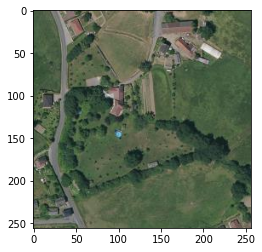

In [10]:
plt.imshow(img)
plt.show()

In [11]:
imgs, labels = next(iter(dm.train_dataloader(batch_size=25)))
imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels

(torch.Size([25, 256, 256, 3]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor([ 6745,  7299,   769,  8809,   473,   593,   434,   653,  1113,  7958,
           431, 10896,   407,  6526,  5057,  7671,  6191,  2728,  2421,  1287,
          4903,  3433,   606,  1069,   439]))

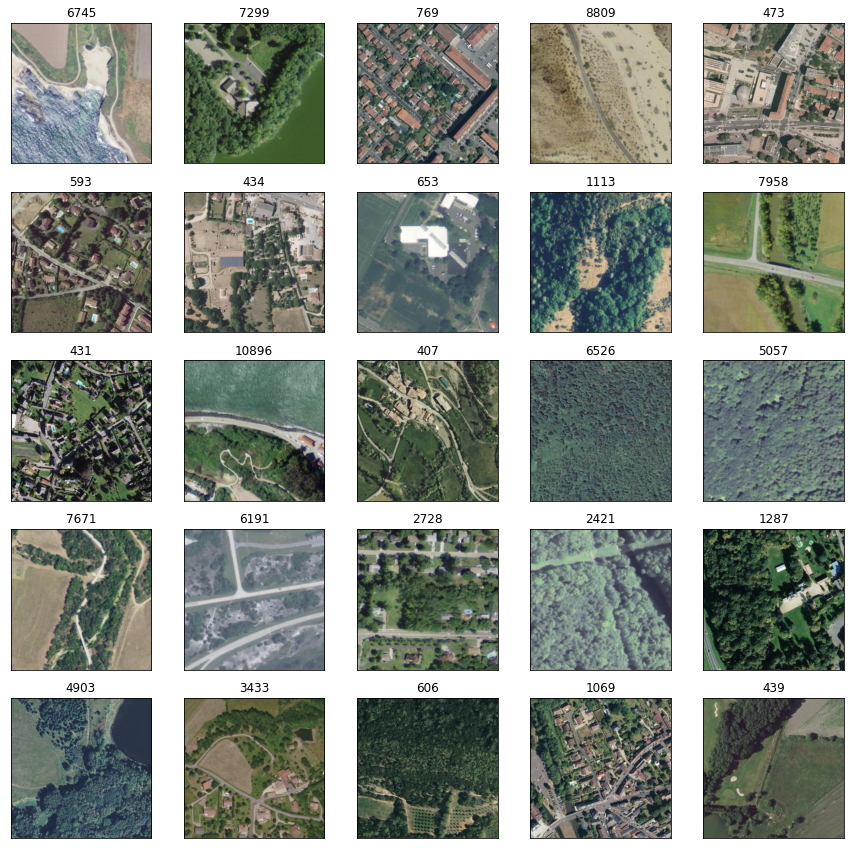

In [12]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i])
    ax.set(xticks=[], yticks=[])
    ax.set_title(labels[i].item())
plt.show()

In [13]:
hparams = {  
    "backbone": "resnet18",
    "pretrained": True,
    "optimizer": "Adam",
    "optimizer_params": {
        "lr": 1e-3,
    }
}

module = RGBModule(hparams)
outputs = module(imgs)
outputs.shape

torch.Size([25, 17037])

In [14]:
if __name__ == "__main__":
    hparams = {
        "datamodule": {
            "batch_size": 256,
            "num_workers": 12,
            "pin_memory": True,
        },  
        "backbone": "resnet18",
        "pretrained": True,
        "optimizer": "Adam",
        "optimizer_params": {
            "lr": 1e-3,
        }
    }

    dm = RGBDataModule(**hparams["datamodule"])
    module = RGBModule(hparams)

    trainer = pl.Trainer(
        gpus=1,
        max_epochs=10,
        enable_checkpointing=False,
        logger=None,
        #overfit_batches=1,
    )

    trainer.fit(module, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 19.9 M
---------------------------------
19.9 M    Trainable params
0         Non-trainable params
19.9 M    Total params
79.666    Total estimated model params size (MB)


train: 1587395
val: 40080
test: 36421


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
